# Assignment IT107 for Object Detection Test

<b>Student ID</b>: 23A054Q<br />
<b>Student Name</b>: Allen Lee

This is a Jupyter notebook to validate the saved model on detection for the giant panda and red panda on test image and test videos.

In [1]:
# Import all required libraries
import os
import pathlib

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from six import BytesIO
from PIL import Image
from tqdm import tqdm
import tensorflow as tf
import cv2
from PIL import Image

2023-12-24 22:23:30.325687: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-24 22:23:30.325763: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-24 22:23:30.442796: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-24 22:23:30.698329: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-24 22:23:32.054825: W tensorflow/compiler/tf2

### Utility to load image

In [2]:
def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
    path: the file path to the image

    Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
    """
    image = None
    if(path.startswith('http')):
        response = urlopen(path)
        image_data = response.read()
        image_data = BytesIO(image_data)
        image = Image.open(image_data)
    else:
        image_data = tf.io.gfile.GFile(path, 'rb').read()
        image = Image.open(BytesIO(image_data))

        (im_width, im_height) = image.size
        
    return np.array(image.getdata())[:,:3].reshape(
      (1, im_height, im_width, 3)).astype(np.uint8)


### Import Visualisation Tools

In [3]:
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import ops as utils_ops


### Load Label Map

In [4]:
BASE_DIR = '/home/sokonana/it107_assignment'
PATH_TO_LABELS = os.path.join(BASE_DIR,'data/label_map.pbtxt')
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)
print(category_index)

{1: {'id': 1, 'name': 'Giant panda'}, 2: {'id': 2, 'name': 'Red panda'}}


### Load the Saved Trained Model

In [5]:
model = 'ssd_mobilenet_v2_320x320_coco17_tpu-8'
experiment='run4'
export_root_dir = os.path.join(BASE_DIR, 'exported_models')

# Uncomment the following if you want to use a pretrained balloon detection model
# model_dir = 'mymodel/saved_model'
model_dir = os.path.join(export_root_dir, f'{model}/{experiment}/saved_model')

# load the model
detection_model = tf.saved_model.load(str(model_dir))

2023-12-24 22:23:38.220258: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-24 22:23:38.537312: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-24 22:23:38.537542: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

## 1) Object Detection on Test Image

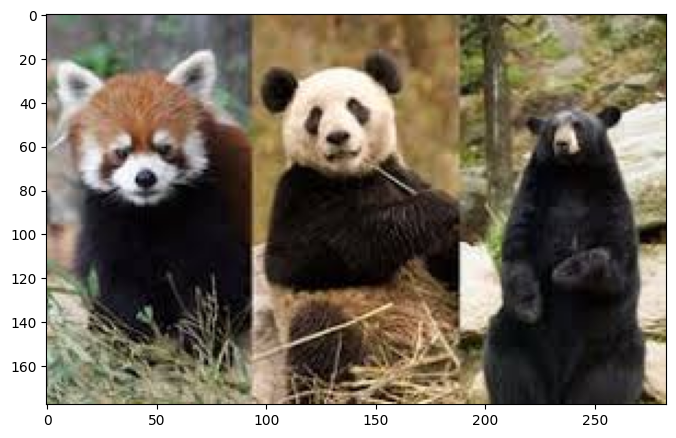

In [6]:
%matplotlib inline

test_sample_path = 'test_samples/test001.jpg'
detected_img_path = 'test_samples/test001_detected.jpg' 

filename = os.path.join(BASE_DIR, test_sample_path)
image_np = load_image_into_numpy_array(filename)
plt.figure(figsize=(8,8))
plt.imshow(image_np[0])
plt.show()


### Inference Using Saved Model

In [7]:
# Apply loaded detection model on test image
results = detection_model(image_np)

# different object detection models have additional results
result = {key:value.numpy() for key,value in results.items()}
print(result.keys())

2023-12-24 22:23:45.206259: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904


dict_keys(['detection_boxes', 'detection_classes', 'raw_detection_boxes', 'num_detections', 'raw_detection_scores', 'detection_scores', 'detection_multiclass_scores', 'detection_anchor_indices'])


### Visualising the Results

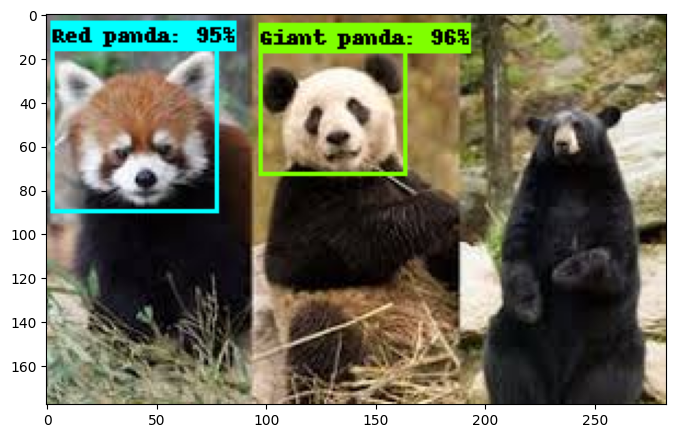

In [8]:
label_id_offset = 0
image_np_with_detections = image_np.copy()

# Drawing the box around objects detected
viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections[0],
      result['detection_boxes'][0],
      (result['detection_classes'][0] + label_id_offset).astype(int),
      result['detection_scores'][0],
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=100,
      min_score_thresh=.70,
      agnostic_mode=False,
      line_thickness=2)

plt.figure(figsize=(8,8))
plt.imshow(image_np_with_detections[0])
plt.show()

# Save the detected image
detected_img = Image.fromarray(image_np_with_detections[0])
detected_img.save(os.path.join(BASE_DIR,detected_img_path ))

## 2) Object Detection on Video

In [9]:
# Function to perform object detection on video, frame-by-frame
label_id_offset = 0
def write_video(video_in_filepath, video_out_filepath, detection_model):
    if not os.path.exists(video_in_filepath):
        print('video filepath not valid')
    
    video_reader = cv2.VideoCapture(video_in_filepath)
    
    nb_frames = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_h = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frame_w = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    fps = video_reader.get(cv2.CAP_PROP_FPS)
    
    video_writer = cv2.VideoWriter(video_out_filepath,
                               cv2.VideoWriter_fourcc(*'mp4v'), 
                               fps, 
                               (frame_w, frame_h))

    for i in tqdm(range(nb_frames)):
        ret, image_np = video_reader.read()
        input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.uint8)
        results = detection_model(input_tensor)
        viz_utils.visualize_boxes_and_labels_on_image_array(
                  image_np,
                  results['detection_boxes'][0].numpy(),
                  (results['detection_classes'][0].numpy()+ label_id_offset).astype(int),
                  results['detection_scores'][0].numpy(),
                  category_index,
                  use_normalized_coordinates=True,
                  max_boxes_to_draw=200,
                  min_score_thresh=.40,
                  agnostic_mode=False,
                  line_thickness=2)

        video_writer.write(np.uint8(image_np))
                
    # Release camera and close windows
    video_reader.release()
    video_writer.release() 
    cv2.destroyAllWindows() 
    cv2.waitKey(1)

In [10]:
from pathlib import Path
samples_folder = os.path.join(BASE_DIR, 'test_samples')
panda_path = os.path.join(samples_folder, 'test_vid01.mp4')

# Test video on Giant Panda detection
basename = Path(panda_path).stem
video_out_file = os.path.join(samples_folder, basename + '_detected.mp4')

write_video(panda_path, video_out_file, detection_model)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:21<00:00, 73.62it/s]


<p><b>Observation</b>: The detection and classification on the test video for Giant Panda is much more successful compared to the part of the video with Red Panda.  There are quite many frames where the model mis-classify the Red Panda for Giant Panda, even though it correctly located its face.</p>  
<p>This could be due to the simpler monochrome colour on the Giant Panda face, compared to the Red Panda which has a more variation of colours and patterns on its face, especially under different lightings and contrast settings. This is also reflected in the poorer classification loss (overfitting) compared to the localisation loss on evaluation samples during training of the models.  This could be improved from collection of more training samples on the Red Panda with wider variations.</p>
